Train one XGBoost model to predict streamflow for all stations. Forcings are aggregated from hourly to daily to match streamflow resolution. RandomSearchCV to find good parameters.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190908-081744'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
param_dist = {
    #'max_depth': sp.stats.randint(2, 8),
    #'learning_rate': sp.stats.uniform(0.005, 0.1),
    #'gamma': sp.stats.uniform(0, 5),
    #'min_child_weight': sp.stats.randint(1, 30),
    'subsample': sp.stats.uniform(0.5, 0.5),
    #'colsample_bytree': sp.stats.uniform(0.3, 0.7),
    #'colsample_bylevel': sp.stats.uniform(0.3, 0.7),
    #'reg_alpha': sp.stats.expon(0, 20),
    #'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

data = data.join(pd.get_dummies(data['station'], prefix='station'))
print(data.shape)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()

test = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

xgb_model = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.07772412167354457, reg_alpha=31.11751470866256, reg_lambda=0.5993909134225779, colsample_bylevel=0.8085379795312839, colsample_bytree=0.5435742710880977, gamma=4.480515316405051, max_depth=6, min_child_weight=4, n_jobs=2, random_state=123)
m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=20, cv=2, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=40, random_state=123, verbose=5)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=100, verbose=False)

cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
print('Best params: {}'.format(m.best_params_))
print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])

test = test[~pd.isna(test['runoff'])]

predict = test.copy()
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(82918, 8773)
Shapes: train (44081, 8773), val (4897, 8773), test (33580, 8773)
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   6 out of  40 | elapsed: 21.5min remaining: 121.9min
[Parallel(n_jobs=40)]: Done  15 out of  40 | elapsed: 22.4min remaining: 37.4min
[Parallel(n_jobs=40)]: Done  24 out of  40 | elapsed: 22.8min remaining: 15.2min
[Parallel(n_jobs=40)]: Done  33 out of  40 | elapsed: 23.4min remaining:  5.0min
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed: 24.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


   param_subsample  mean_test_score  mean_train_score
2         0.613426     -1076.337202         -5.804668
17        0.587726     -1079.991972         -6.189464
10        0.671589     -1084.130027         -5.300085
9         0.696059     -1091.736064         -5.020361
16        0.591246     -1098.700969         -6.218790
Best params: {'subsample': 0.6134257267821015}
mean_train_score   -5.80467
mean_test_score    -1076.34
Name: 2, dtype: object


02GA010 	NSE: 0.36822268454542617 	MSE: 301.214712405108 (clipped to 0)
02GA018 	NSE: 0.38823276805394025 	MSE: 153.64728603018082 (clipped to 0)
02GA038 	NSE: 0.3251916305593172 	MSE: 111.03192783051291 (clipped to 0)
02GA047 	NSE: 0.2430091803205292 	MSE: 59.34052902559241 (clipped to 0)
02GB001 	NSE: 0.28740803148110583 	MSE: 5351.476751103373 (clipped to 0)
02GB007 	NSE: 0.4495993670659788 	MSE: 17.212136589730616 (clipped to 0)
02GC002 	NSE: 0.5879849046600749 	MSE: 52.945190060632214 (clipped to 0)
02GC007 	NSE: 0.4899187199323908 	MSE: 15.364333946558952 (clipped to 0)
02GC010 	NSE: 0.4958106416167394 	MSE: 29.974016919327546 (clipped to 0)
02GC018 	NSE: 0.46154502515161433 	MSE: 36.467833318913264 (clipped to 0)
02GC026 	NSE: 0.5646805354768115 	MSE: 70.01362806245541 (clipped to 0)
02GD004 	NSE: 0.4578354810463787 	MSE: 29.85324470905089 (clipped to 0)
02GE007 	NSE: 0.4282034447427745 	MSE: 20.684773824880267 (clipped to 0)
02GG002 	NSE: 0.6369805917112861 	MSE: 87.55404693914

../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04166500 	NSE: 0.6536120118716138 	MSE: 11.972655690858684 (clipped to 0)
04174500 	NSE: 0.27758166514654636 	MSE: 68.32216251435175 (clipped to 0)
04176500 	NSE: 0.2068427768260137 	MSE: 541.7852486802791 (clipped to 0)
04177000 	NSE: 0.2529159422788668 	MSE: 20.133788210131097 (clipped to 0)
04193500 	NSE: 0.6227013022247885 	MSE: 26713.030500264176 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04195820 	NSE: 0.5043047551258639 	MSE: 581.8442704523633 (clipped to 0)
04196800 	NSE: 0.4975163269691151 	MSE: 150.36747888565407 (clipped to 0)
04197100 	NSE: 0.5699651178688196 	MSE: 44.106273854836 (clipped to 0)
04198000 	NSE: 0.5467601887897844 	MSE: 3348.3360286371417 (clipped to 0)
04199000 	NSE: 0.4726454811049151 	MSE: 539.2744711790856 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04199500 	NSE: 0.4397468296464154 	MSE: 226.70539320578308 (clipped to 0)
04200500 	NSE: 0.5067158529882558 	MSE: 493.6318905853702 (clipped to 0)
04207200 	NSE: 0.4416148602313025 	MSE: 13.069725236074623 (clipped to 0)
04208504 	NSE: 0.5619678489981293 	MSE: 427.75094777849654 (clipped to 0)
04209000 	NSE: 0.4860797767348176 	MSE: 160.6802495474002 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04212100 	NSE: 0.5705417765079819 	MSE: 630.5842620384739 (clipped to 0)
04213000 	NSE: 0.49105679727861506 	MSE: 91.33964795479076 (clipped to 0)
04213500 	NSE: 0.6188476555134167 	MSE: 390.45888159978074 (clipped to 0)
04214500 	NSE: 0.5576631069267237 	MSE: 53.31800058801879 (clipped to 0)
04215000 	NSE: 0.47047027581005096 	MSE: 50.86281948014354 (clipped to 0)
04215500 	NSE: 0.5394232524422959 	MSE: 83.17321121819757 (clipped to 0)
Median NSE (clipped to 0) 0.4934337194476772 / Min 0.2068427768260137 / Max 0.6602733153925534
Median MSE (clipped to 0) 80.82039267895166 / Min 3.8293522157450504 / Max 26713.030500264176


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

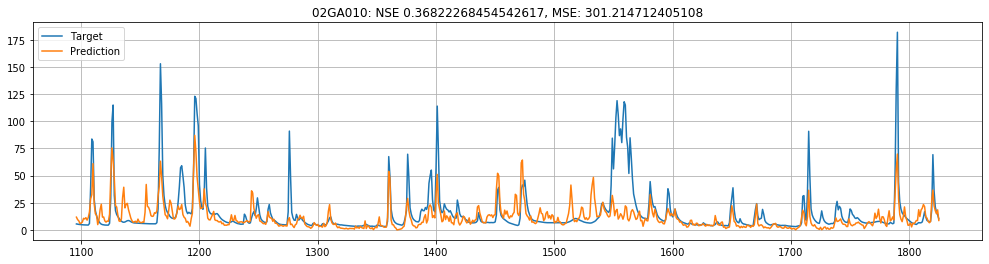

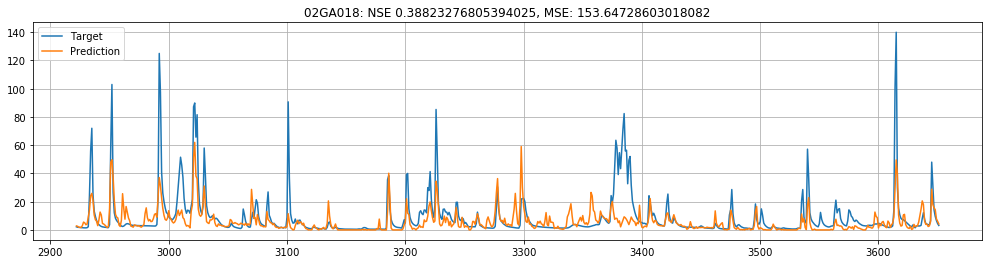

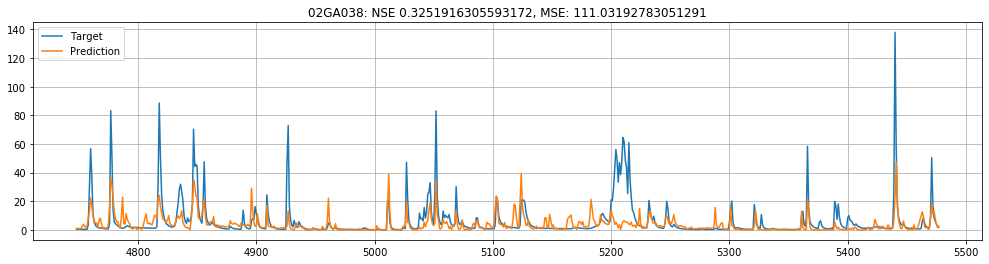

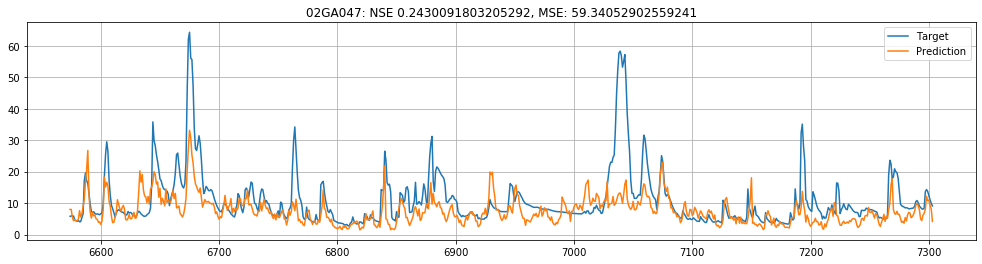

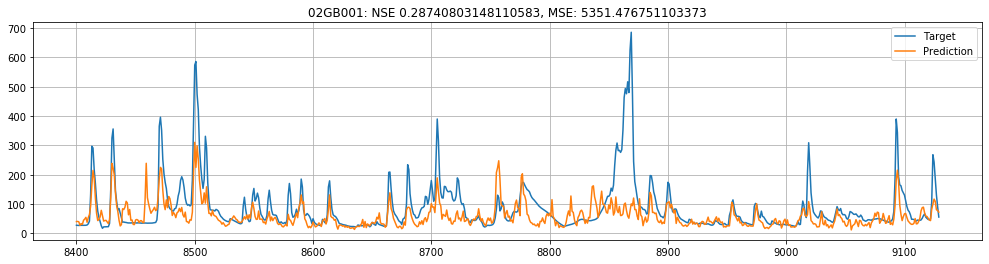

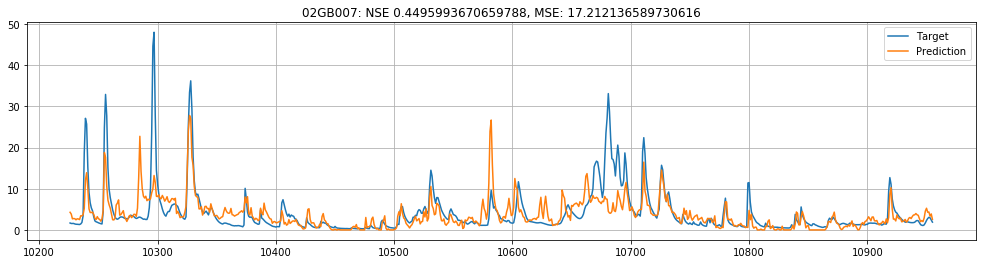

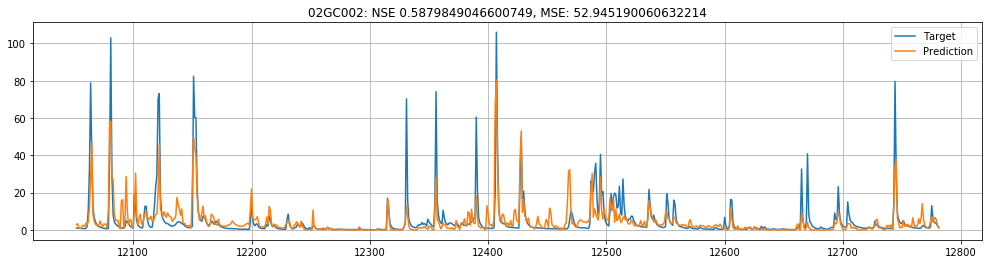

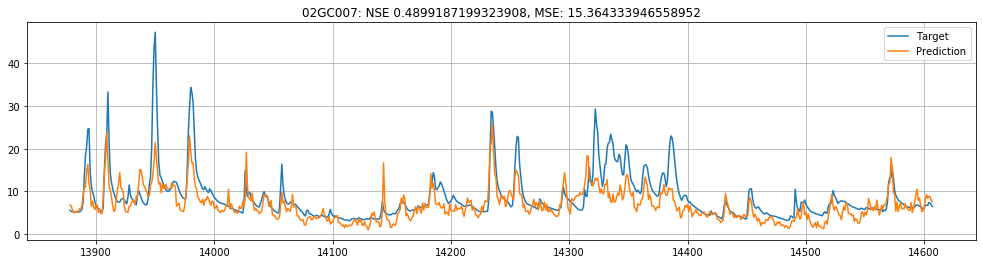

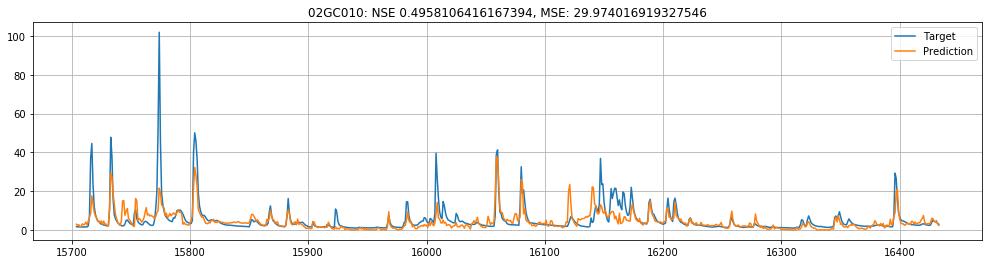

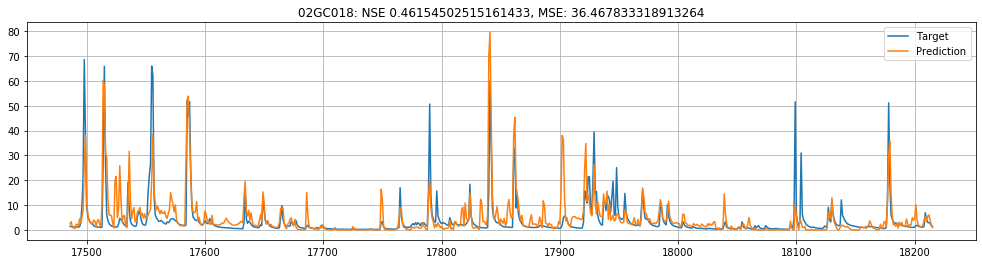

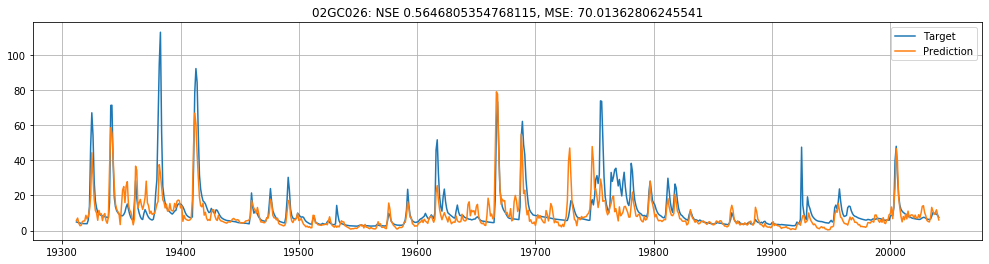

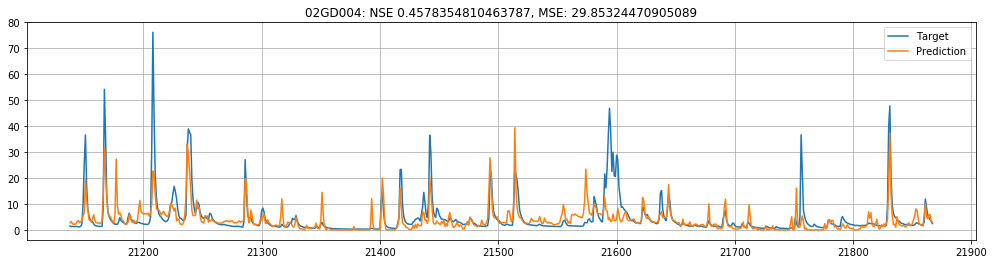

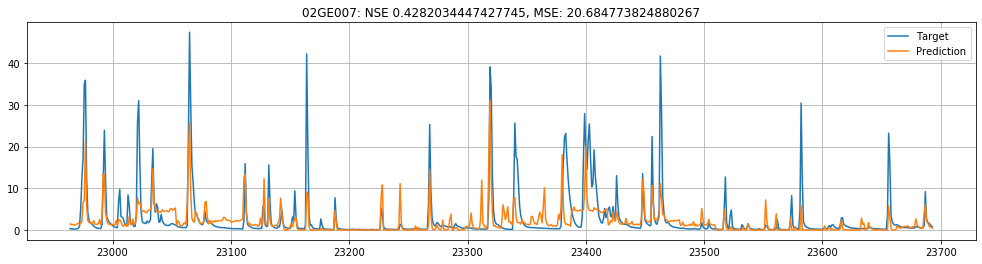

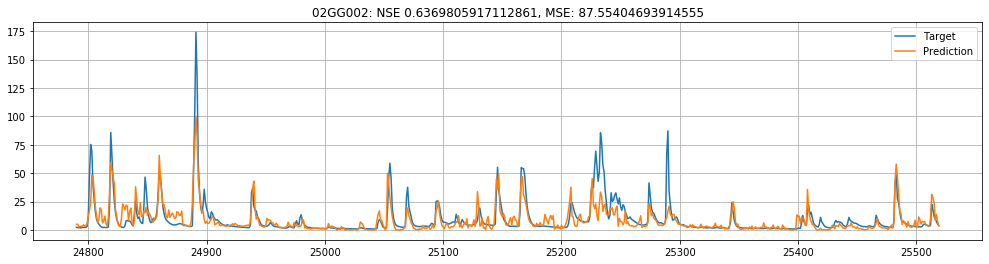

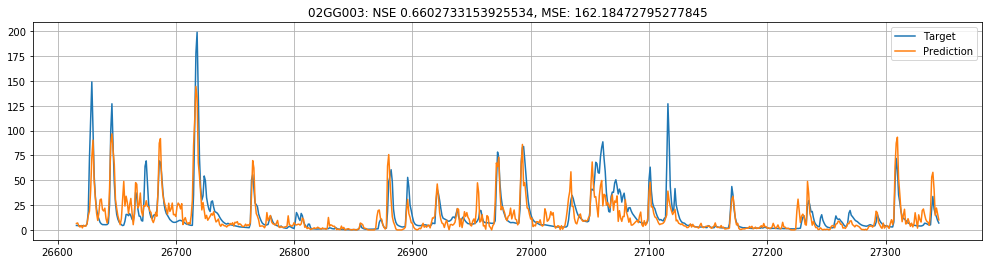

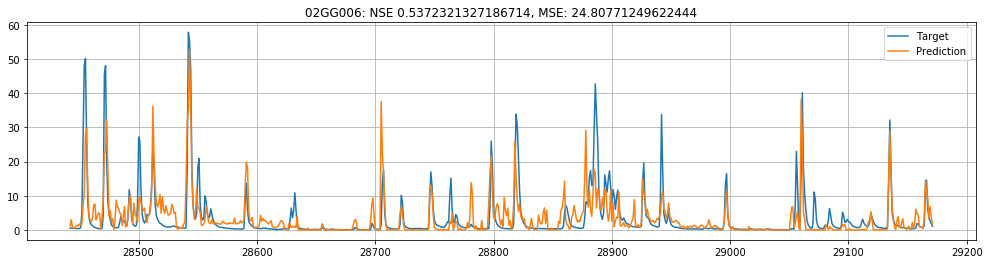

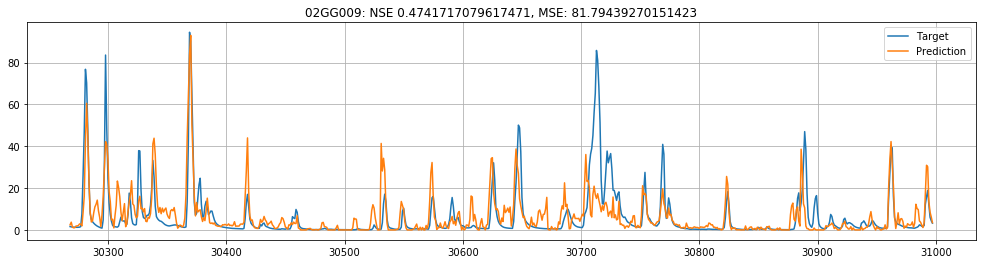

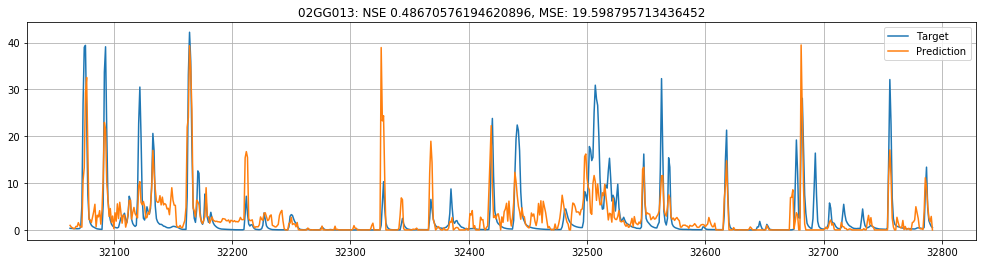

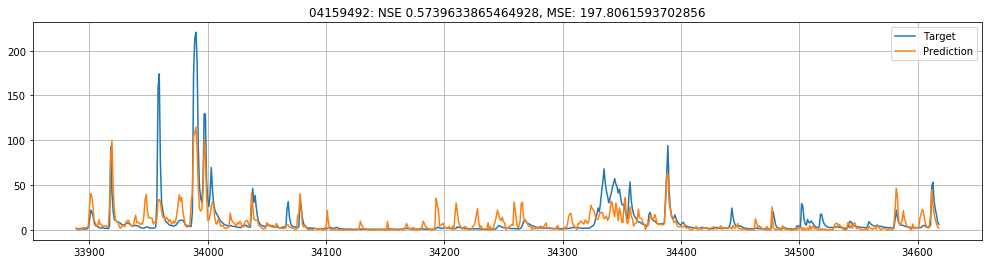

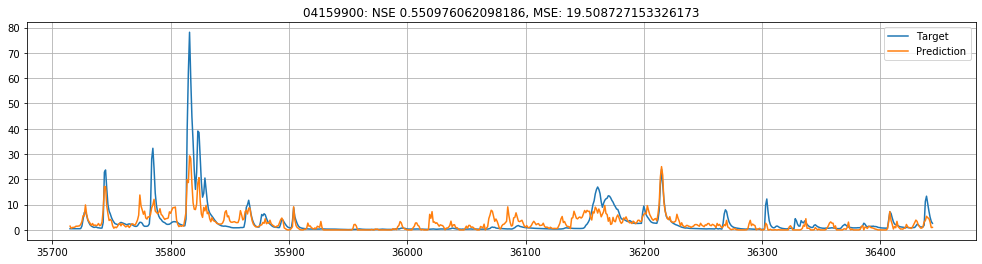

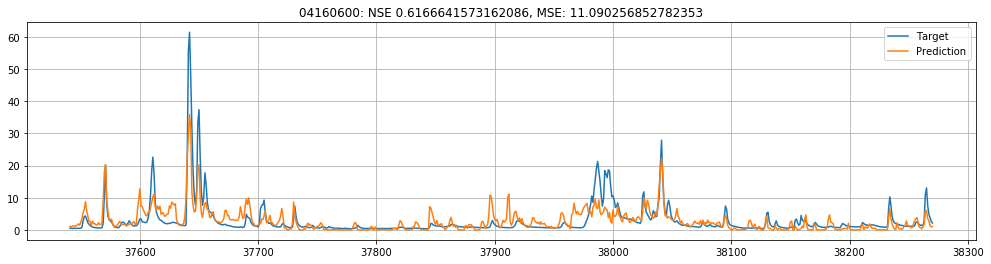

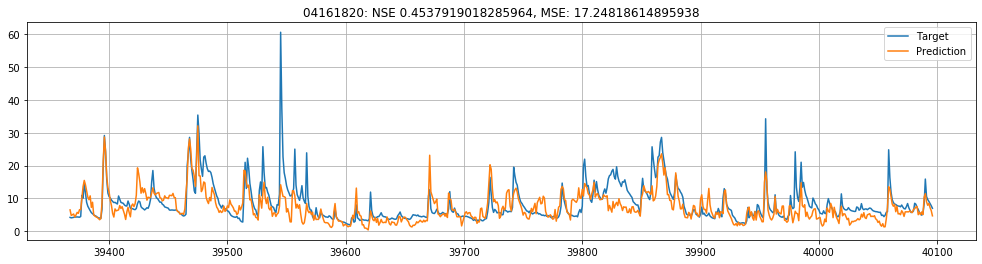

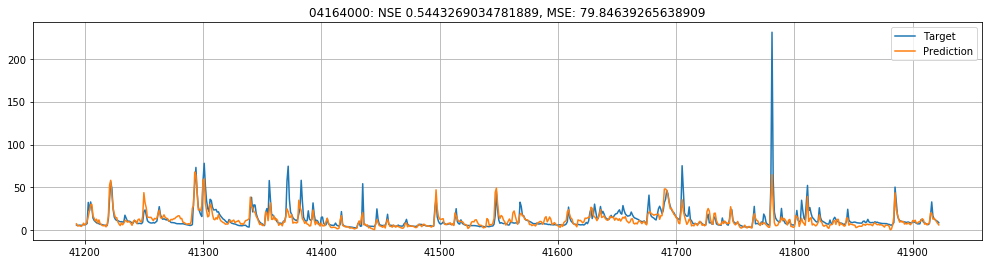

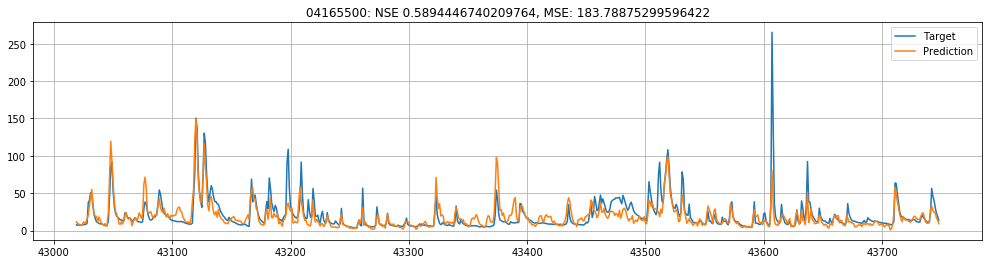

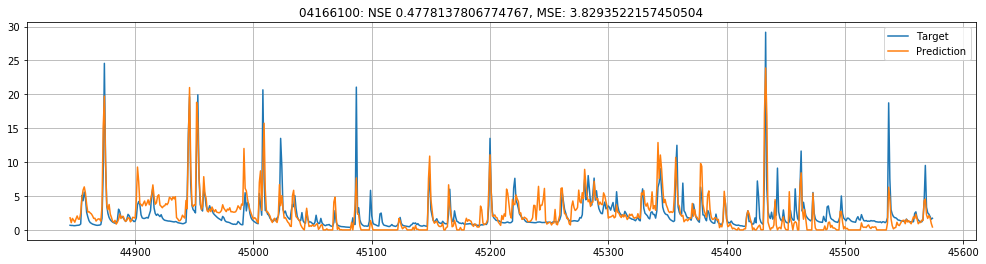

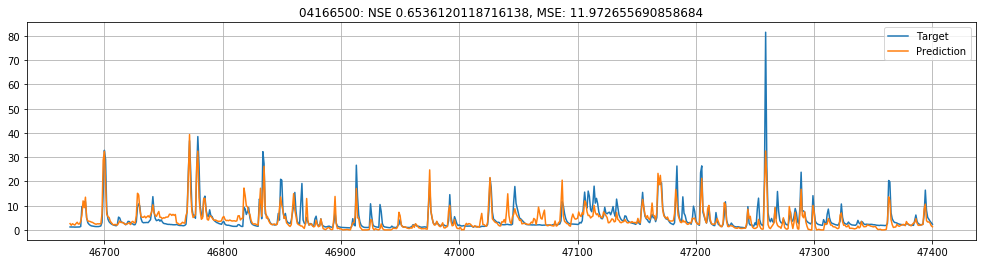

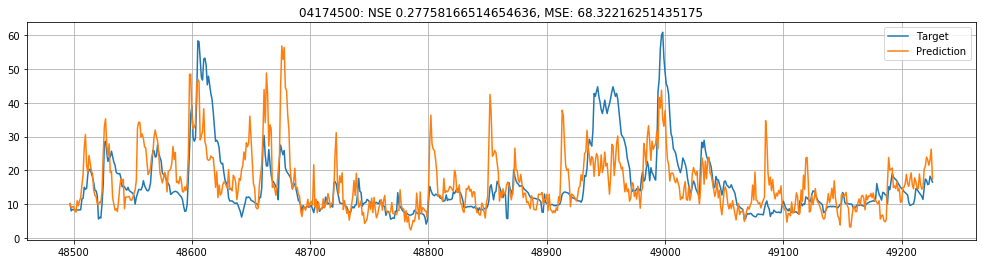

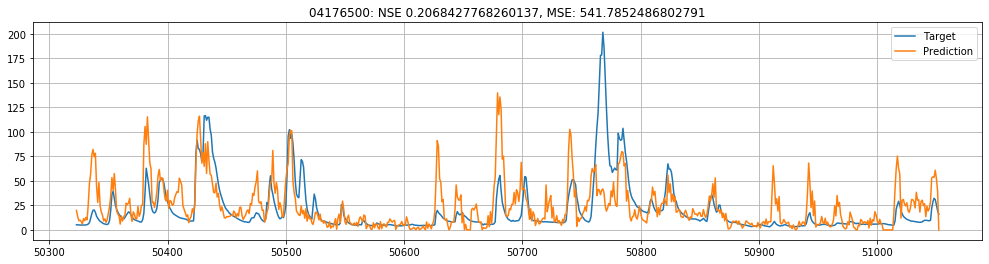

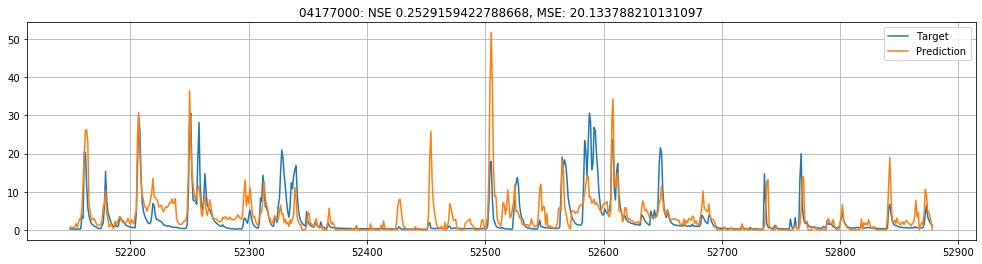

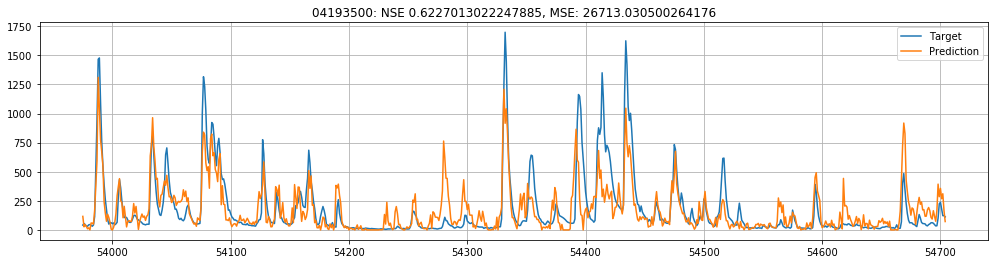

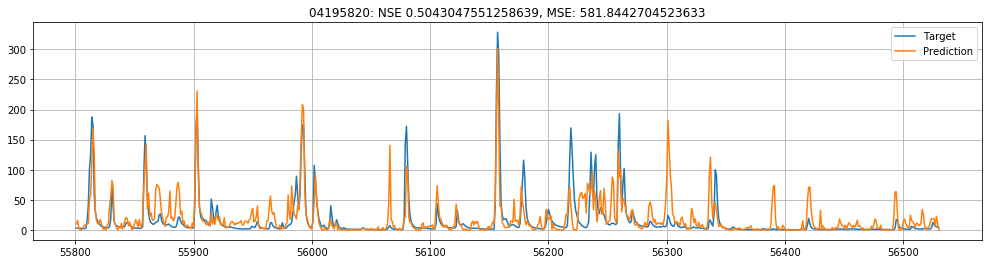

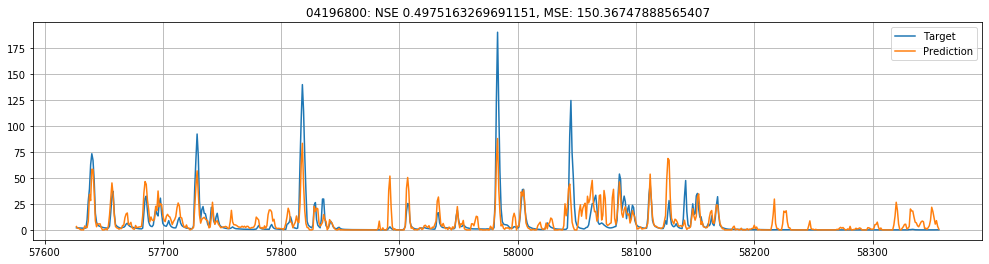

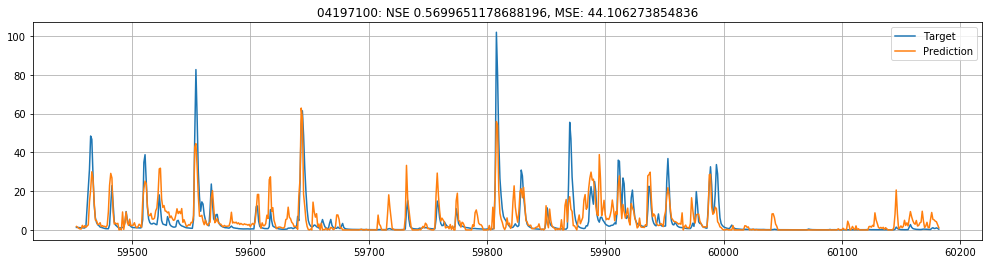

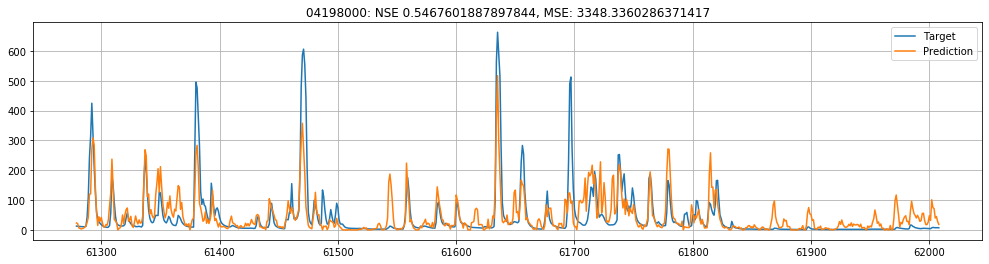

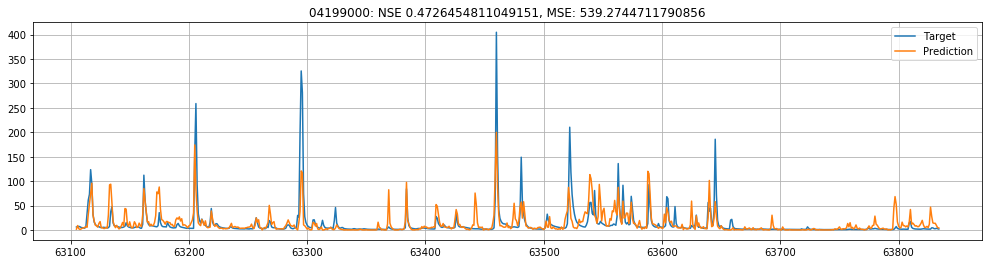

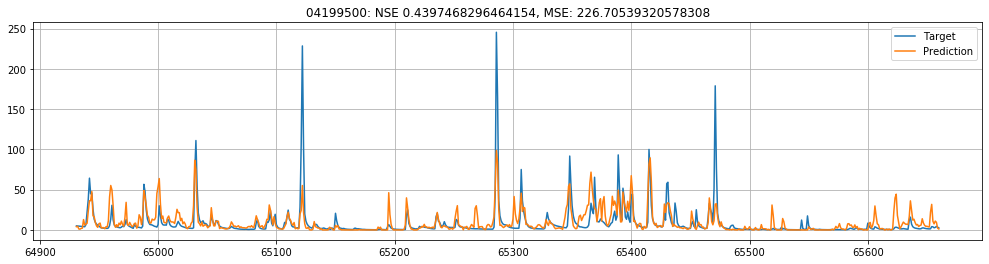

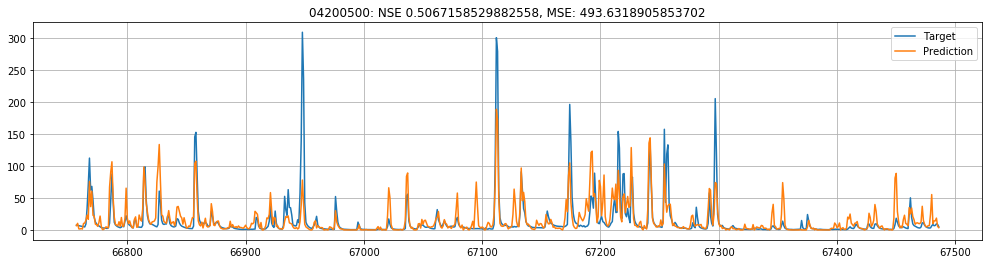

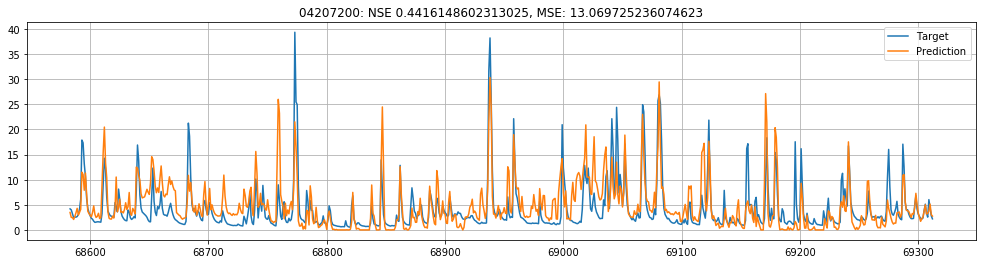

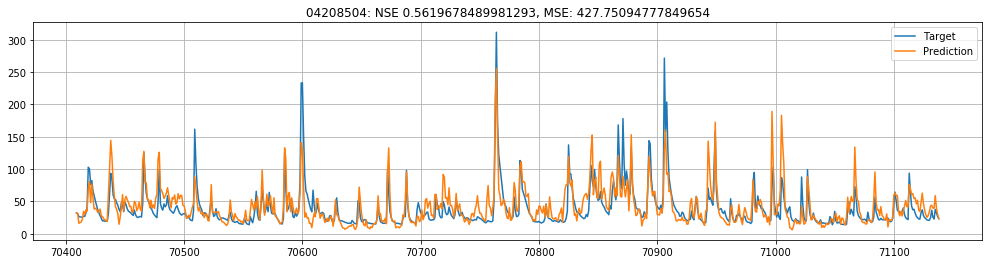

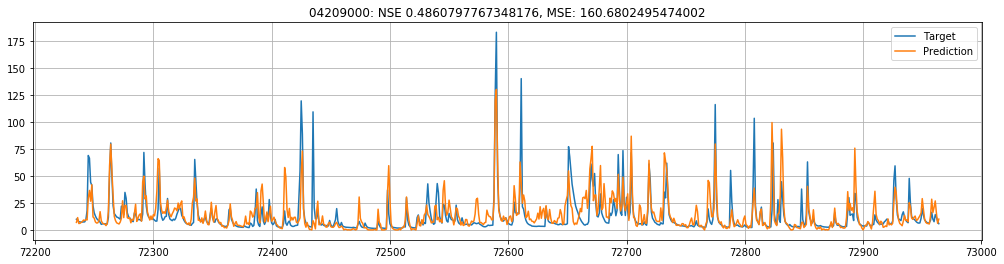

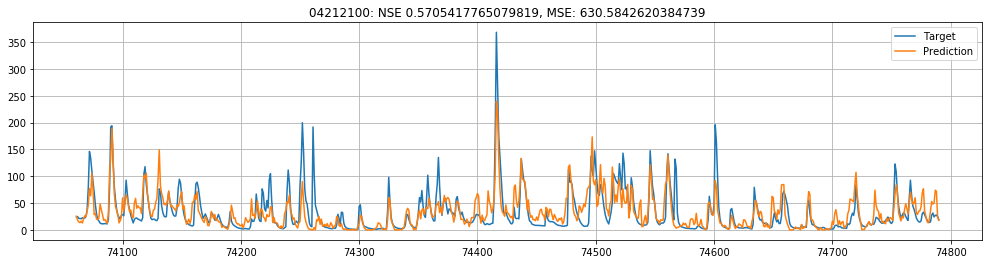

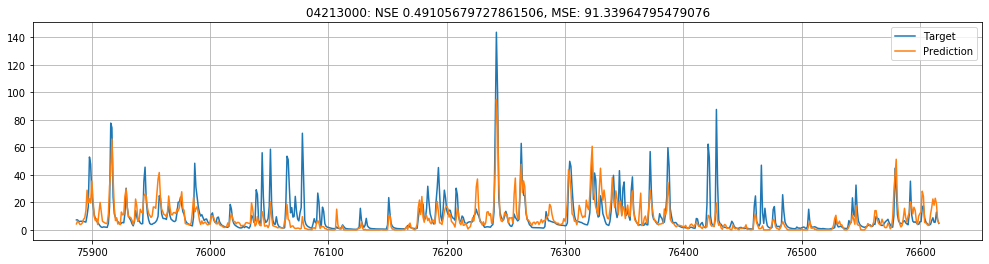

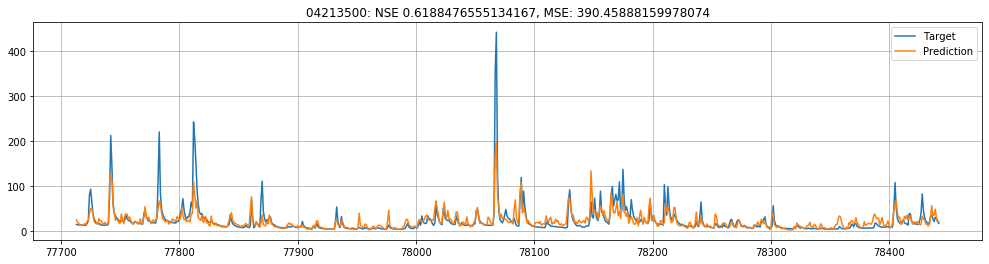

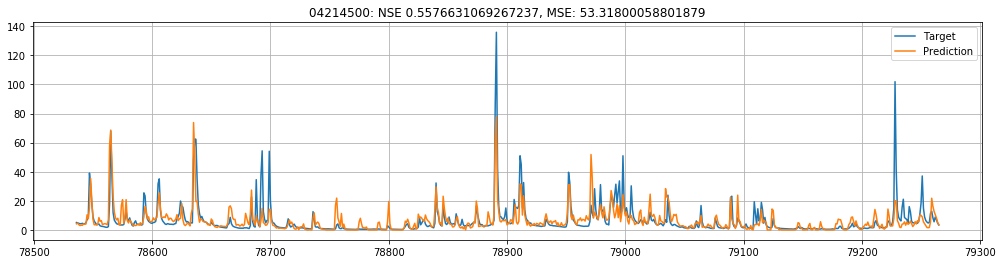

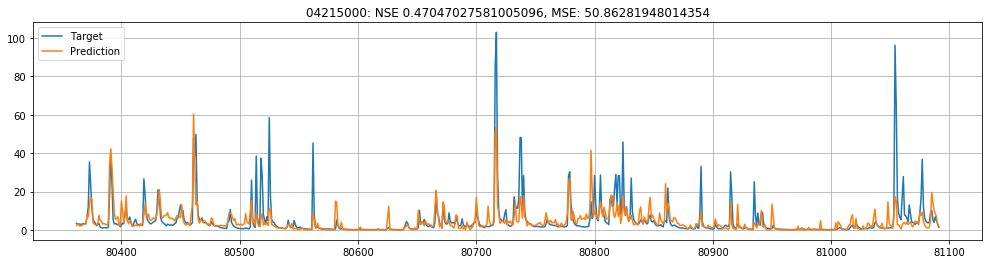

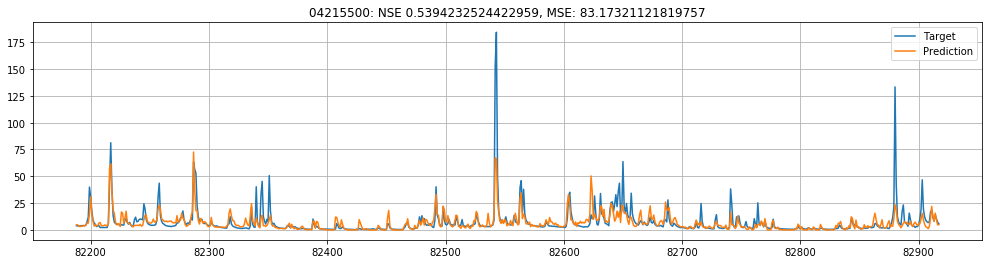

In [5]:
nse_list = []
mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [6]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_oneModel', predict[['date', 'station', 'runoff', 'actual']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_oneModel_20190908-081744.pkl'

In [7]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_oneModel', m, 'all', time_stamp, model_type='sklearn')

Saved model as /home/mgauch/runoff-nn/src/../pickle/models/XGBoost_VIC_aggregateForcings_oneModel_all_20190908-081744.pkl
